# Exercise 5: Use Flux for Logistic Regression:

Para este ejercicio se usaron dos bibliotecas de *ML* para ajustar los datos de *Churn_Modelling.csv*: **GLM** y **Flux**. Del siguiente reporte veremos que aunque **GLM** es una biblioteca relativamente facil de usar (y ajustar), el mayor nivel de personalización de **Flux** permite que el ajuste del modelo sea más fino, llegando con eso a obtener predicciones de mejor calidad (cosa que yo no obtengo por falta de experiencia en el ajuste de parametros de **Flux**).<br><br>

Ambas partes del código están altamente basadas en las *demos* para **GML** y **Flux** de las sesiones de los dias [22/11](https://drive.google.com/drive/u/0/folders/1fJljfJ1T1QIh7joKgCuaSWy6h6udzUEd) y [23/11](https://drive.google.com/drive/u/0/folders/1fJljfJ1T1QIh7joKgCuaSWy6h6udzUEd) respectivamente.



In [1]:
import Pkg 

#=
Pkg.activate("new_env")
Pkg.Registry.rm("General")
Pkg.Registry.add("General")
Pkg.activate(".")
=#


Pkg.add("CSV")
Pkg.add("Plots")
Pkg.add("GLM")
Pkg.add("StatisticalMeasures")
Pkg.add("Plots")
Pkg.add("ScikitLearn")
Pkg.add("MLBase")
Pkg.add("Random")
Pkg.add("CategoricalArrays")
Pkg.add("Measures")
Pkg.add("Flux")

import Pkg; Pkg.offline(true)


using CSV, DataFrames, Statistics, Plots, GLM,  StatisticalMeasures, Plots, Random, MLBase, CategoricalArrays, Measures, Flux, Random
using Plots.PlotMeasures
using Flux: train!


   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to 

### Lectura de datos de CSV a DF

In [20]:
dir_src = @__DIR__
dir_base = joinpath(dir_src, "..")
dir_dat = joinpath(dir_base, "dat")
ruta_datos = joinpath(dir_dat, "Churn_Modelling.csv")

Churn = DataFrame(CSV.File(ruta_datos));

println(first(Churn,10))

10×14 DataFrame
 Row │ RowNumber  CustomerId  Surname   CreditScore  Geography  Gender   Age    Tenure  Balance        NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited 
     │ Int64      Int64       String31  Int64        String7    String7  Int64  Int64   Float64        Int64          Int64      Int64           Float64          Int64  
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │         1    15634602  Hargrave          619  France     Female      42       2      0.0                    1          1               1        1.01349e5       1
   2 │         2    15647311  Hill              608  Spain      Female      41       1  83807.9                    1          0               1        1.12543e5       0
   3 │         3    15619304  Onio              502  France     Female      42       8      1.59661e5              3          1         

### Definimos todas nuestras funciones en un solo bloque

Aquí estamos heredando gran parte de las funciones de los problemas 2 y 3 ya que son las que usaremos para preparar los datos para su posterior uso en el ajuste de los modelos. Ademas, definimos algunas otras nuevas como funciones que nos permitiran obtener matrices de confución y curvas de ROC de manera sencilla. <br><br>

Aquí menciono que la funcion **ROC_plotter** hace contraste con el *metodo* que se uso para obtener la *curva de ROC* en el ejericicio 3, ya que en esa ocación se usó la bilioteca **ROCAnalysis**. Esto pues la poca documentación disponible y el abandono del paquete hacen muy complicado su uso, ademas de que se demostro (en parte) que las habilidades de graficación de **ROCAnalysis** son limitados; por otro lado **ROC_plotter** es una función corta y facil de entender. <br><br>

**NOTA:** Ademas de los problemas demostrados, no se volvio a usar **ROCAnalysis**, porque el tipo de datos de la función **ROCAnalysis.roc()** la hacen "caprichosa", ademas de que, como ya se mencionó, la poca documentación no ayuda, y realmente era más facil implementar una función de cero que pelearse; sin, embargo, no se sustituyó **ROCAnalysis** en el ejercicio 3 ya que queria conservar la evidencia de una manera pre-establecida de obtener la curva de ROC.


In [21]:
# Funcion para hacer display de numero de columnas y filas
function dataShape(df)
    # Imprimimos no de col y no de filas
    println("Num of rows: $(size(df,1))")
    println("Num of cols: $(size(df,2))")
end



# Funcion para contar missing X columna
function count_missing(col)
    count(ismissing,col)
end



# Funcion para obtener el porcentaje de missing de cada columna
function missing_percentage(col)
    count_missing(col)/length(col)*100
end


# Funcion para imprimir nombre/ tipo / porcentaje de missing como una tabla
function insigth_display(df)
    insigth = DataFrame(
        "Name" => names(df),
        "Type" => eltype.(eachcol(df)),
        "miss_per" => [missing_percentage(col) for col in eachcol(df)]
    )
    println(insigth)
end


# Funcion para quitar outlier 
function removeOutliersIQR(df)

    # vovlemos a calcular las col numericas
    numerical_columns = num_cols(df)
    # para cada una obtenemos el iqr y usamos un umbral de 1.5
    for col in numerical_columns
        q1, q3 = quantile(df[!,col],[0.25,0.75])
        iqr = q3 - q1

        low_lim = q1 - 1.5 * iqr
        upp_lim = q3 + 1.5 * iqr

        # actualizamos el df en cada iteracion
        df = filter(row -> low_lim <= row[col] <= upp_lim, df)
    end  
    return df  
end


# Funcion para sacar la matriz de correlacion
function calculateCorrelation(df)

    numerical_columns = num_cols(df)
    #= Eliminamos las filas con missing en las columnas numéricas
    antes de calcular la matriz de correlación para evitar que los coeficientes sean nulos=#
    filtered_df = dropmissing(df[:, numerical_columns])  
    return cor(Matrix(filtered_df))


end


function displayCorrelation(df,saveplot::String,plotname::String,font_z::Int)

    # Volvemos a calcular estos parametros para poder reflejar el estado actual del df 
    correlation_matrix = calculateCorrelation(df)
    numerical_columns = num_cols(df)
    xlabel = ylabel = string.(numerical_columns)  # Usar nombres de las columnas en los ejes
    nrow, ncol = size(correlation_matrix)
    
    # Grafica el heatmap
    plot_obj=heatmap(correlation_matrix, xticks=(1:ncol, xlabel), yticks=(1:nrow, ylabel),
        fill_z=correlation_matrix, xrotation=45)
    
    # Tamaño de la fuente 
    fontsize = font_z
    
    # Anotamos los valores de correlación en cada cajita
    ann = [(i, j, text(round(correlation_matrix[i, j], digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
    annotate!(ann, linecolor=:white)

    if saveplot == "yes"
        dir_src = @__DIR__
        dir_base = joinpath(dir_src, "..")
        dir_fig = joinpath(dir_base, "fig")
        savefig(joinpath(dir_fig, plotname))
    else
        return plot_obj
    end
    return plot_obj
end

# Funcion para obtener columnas numericas
function num_cols(df)

    #= Obtenenos las columas numericas del df como todas aquellas que tienen tipos Union{Missing, Number}
    Hacemos eso ya que gran parte de los datos tienen datos missing, y la naturaleza de Julia define las 
    columnas con missgin como  Union{Missing, T}=#
    cols = [col for col in names(df) if eltype(df[!,col]) <: Union{Missing, Number}]
    #cols = [col for col in names(df) if eltype(df[!,col]) <: Number]
    return cols
end

function filterColumnsByCorrelation(df::DataFrame, target::String, threshold::Float64, relation::Bool)
    # Calcula la matriz de correlación y obtiene los nombres de las columnas numéricas
    corr_matrix = calculateCorrelation(df)
    numerical_columns = num_cols(df)
    
    if !(target in numerical_columns)
        println("La columna objetivo '$target' debe ser numérica y válida.")
        return
    end

    # Crear un diccionario para mapear los nombres de las columnas con la matriz de correlación
    corr_map = Dict(numerical_columns[j] => corr_matrix[j, findfirst(==(target), numerical_columns)] 
                    for j in 1:length(numerical_columns) if numerical_columns[j] != target)
    
    # Filtrar las columnas en base al umbral y la relación
    for (key, val) in corr_map
        if relation == false && abs(val) <= abs(threshold)
            select!(df, Not(key))  # Eliminar la columna del DataFrame
        elseif relation == true && val >= threshold
            select!(df, Not(key))  # Eliminar la columna del DataFrame
        end
    end

    return df
end


# Funcion para tomar una columna categorica y obtener información cuantitativa
function encoder(df::DataFrame, col::String)

    # Creamos una nueva columan _Encoded
    encoded_col = Symbol(col * "_Encoded")
    # hacemos una lista de los valores unicos de la columna
    categories = unique(df[!, Symbol(col)])  
    # a cada categoria le asignamos un valor numerico
    category_dict = Dict(category => i for (i, category) in enumerate(categories))  
    # Imprimimos la nueva clasificacion sobre la nueva columna 
    df[:, encoded_col] = [category_dict[x] for x in df[!, Symbol(col)]]  
    return df  
end

# Funcion para obtener MSE 
function mse(y_true, y_pred)
    return mean((y_true .- y_pred).^ 2)
end

# Conservamos la funcion Mat_to_bin pero solo la parte posterior a la selección del mejor vector
function Proba_to_bin(proba_vect, threshold)
    
    # Convertimos la columna óptima a un vector binario basado en el umbral
    #binary_vect = Int.(proba_vect .> threshold)
    binary_vect = ifelse.(proba_vect .< threshold, 0, 1)
    # Imprimimos las primeras 10 predicciones binarizadas para verificar resultados
    println("Predicciones para el método (10): ", binary_vect[1:10])

    
    # Retornamos el vector binario y la columna óptima de predicciones continuas
    # Necesitamos binary_vect para la martiz de confucion y best_vect para la curva de ROC
    return binary_vect
end

# Funcion que extrae los valores de FPR y TPR dada una curva de ROC
function extraer_fpr_tpr(roc_curve)
    fpr = roc_curve.pfa  # Tasa de falsos positivos
    tpr = 1 .- roc_curve.pmiss  # Tasa de verdaderos positivos
    return fpr, tpr
end


#Funcion para dividir el DF (tomada del profesor)
function splitter(df,porcentaje)
    dfsize = size(df)
    nrows = dfsize[1]
    rows2train = round(Int, (nrows*porcentaje))

    # Aqui usamos una muestra aleatoria de tamalo determinado por rows2train en ves de las primeras rows2train entradas
    train_indices = shuffle(1:nrows)[1:rows2train]
    test_indices = setdiff(1:nrows, train_indices)
    dfTrain = df[train_indices, :]
    dfTest = df[test_indices, :]

    return dfTrain, dfTest
end

function deleteRow(df,col)
   
    # Tomamos el tipo de la columna Union{missing,T} y reasignamos el tipo como solo T
    current_type = eltype(df[!, col])
    T = Base.nonmissingtype(current_type)
    # Ademas borramos las filas con missing
    dropmissing!(df,col)
    df[!, col] = convert(Vector{T}, df[!, col])
    
end

# Implementación manual de trapz
function trapz(x, y)
    sum((x[2:end] .- x[1:end-1]) .* (y[2:end] .+ y[1:end-1]) ./ 2)
end

# Funcion para obtener matrices de confusion
function cm_plotter(pred_vect, true_data, model_name::String)

    cm = confmat(pred_vect, true_data)

    matrices = [cm.mat]
    model_names = [model_name]
    n = length(matrices) 
        heatmaps = [
        begin
            # Crear el heatmap base
            p = heatmap(
                matrices[i],
                xlabel="Predicciones",
                ylabel="Reales",
                xticks=(1:2, ["1", "0"]),
                yticks=(1:2, ["1", "0"]),
                title=model_names[i],
                colorbar=false 
            )

            # Generar las anotaciones al mismo estilo que en ejericio anterior.
            nrow, ncol = size(matrices[i])  # Tamaño de la matriz
            ann = [(x, y, Plots.text(string(matrices[i][y, x]), 12, :grey, :center))
                   for x in 1:ncol, y in 1:nrow]

            # Añadir las anotaciones al heatmap
            annotate!(p, ann...)
            p  # Retornar el gráfico anotado
        end
        for i in 1:n
    ]
    gr()

    p = plot(heatmaps..., size=(1000, 500), margin=5mm)
    plot!(p , colorbar=true, colorbar_position=:right) 
    dir_src = @__DIR__
    dir_base = joinpath(dir_src, "..")
    dir_fig = joinpath(dir_base, "fig")
    savefig(joinpath(dir_fig, "Matriz de confusion para $model_name"))          

    return p, cm
end


# Función para graficar curvas de ROC definida de manera manual
function ROC_plotter(proba_vec, true_data, model_name::String)

    # Ordenamos las probabilidades de predicción en orden descendente
    # y reordenamos las etiquetas 
    data = sortperm(proba_vec, rev=true)
    sorted_scores = proba_vec[data]  
    sorted_true = true_data[data]   

    # Obtenemos los valores distintos de las probabilidades predichas
    thresholds = unique(sorted_scores)


    fpr = Float64[]  
    tpr = Float64[]  

    # Iteramos sobre cada umbral para calcular FPR y TPR
    for thresh in thresholds
        # Generamos predicciones binarias comparando las probabilidades con el umbral actual
        predicted = sorted_scores .>= thresh

        # Calculamos TP, FP, FN y TN
        tp = sum((predicted .== 1) .& (sorted_true .== 1))
        fp = sum((predicted .== 1) .& (sorted_true .== 0))
        fn = sum((predicted .== 0) .& (sorted_true .== 1))
        tn = sum((predicted .== 0) .& (sorted_true .== 0))

        # Calculamos y almacenamos los TPR y FPR para el umbral actual
        push!(tpr, tp / (tp + fn))  
        push!(fpr, fp / (fp + tn)) 
    end

    println("False Positive Rate: ", fpr)
    println("True Positive Rate: ", tpr)

    p = plot(fpr, tpr, label="Curva ROC para $model_name", xlabel="FPR (False Positive Rate)", ylabel="TPR (True Positive Rate)", legend=:bottomright, margin=5mm) 
    plot!(x -> x, 0, 1, linestyle=:dash, color=:gray, label="Línea de referencia")
    dir_src = @__DIR__
    dir_base = joinpath(dir_src, "..")
    dir_fig = joinpath(dir_base, "fig")
    savefig(joinpath(dir_fig, "Curva ROC para $model_name"))          

    return p, fpr, tpr
end

# Función para cobtener TN, FP, FN y TP  a partir de una matriz de confusión
function calculate_metrics(matrix)
    TN, FP = matrix[1, 1], matrix[1, 2]
    FN, TP = matrix[2, 1], matrix[2, 2]
    
    # Cálculamos de las métricas
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)  # Evitar división por cero
    recall = TP / (TP + FN)  # Evitar división por cero
    f1_score = 2 * (precision * recall) / (precision + recall)  # Evitar división por cero
    return accuracy, precision, recall, f1_score, TP, TN, FP, FN
end


calculate_metrics (generic function with 1 method)

## Limpieza y análisis de datos: 

Comenzamos con la parte de análisis de datos. En esta sección usaremos el mismo enfoque del profesor para la clase del 22/11, tratando de replicar sus datos mediente la misma limpieza, pero usando funciones recicladas de tareas anteriores.

In [22]:
# Imprimimos un conteo de las categorias de los datos categóricos que resultan relevantes para el analisis.

# en este caso tenemos al target
println("Mapa para Exit")
@show(GLM.countmap(Churn.Exited))

# y a dos columnas que consideramos relevantes
println("Mapa para Gender")
@show(GLM.countmap(Churn.Gender))
println("Mapa para Geography")
@show(GLM.countmap(Churn.Geography))


Mapa para Exit
GLM.countmap(Churn.Exited) = Dict(0 => 7963, 1 => 2037)
Mapa para Gender
GLM.countmap(Churn.Gender) = Dict{String7, Int64}("Female" => 4543, "Male" => 5457)
Mapa para Geography
GLM.countmap(Churn.Geography) = Dict{String7, Int64}("Germany" => 2509, "Spain" => 2477, "France" => 5014)


Dict{String7, Int64} with 3 entries:
  "Germany" => 2509
  "Spain"   => 2477
  "France"  => 5014

In [23]:
# Usamos la funcíon encoder para obtener versiones cuantitativas de estas columnas que nos serviran para
# obtener un mejor ajuste de los datos

encoder(Churn,"Gender")
encoder(Churn,"Geography")

describe(Churn)


16×7 DataFrame
 Row │ variable           mean       min       median     max        nmissing  ⋯
     │ Symbol             Union…     Any       Union…     Any        Int64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ RowNumber          5000.5     1         5000.5     10000             0  ⋯
   2 │ CustomerId         1.56909e7  15565701  1.56907e7  15815690          0
   3 │ Surname                       Abazu                Zuyeva            0
   4 │ CreditScore        650.529    350       652.0      850               0
   5 │ Geography                     France               Spain             0  ⋯
   6 │ Gender                        Female               Male              0
   7 │ Age                38.9218    18        37.0       92                0
   8 │ Tenure             5.0128     0         5.0        10                0
   9 │ Balance            76485.9    0.0       97198.5    2.50898e5         0  ⋯
  10 │ NumOfProducts      1.5302     1         1.0        4                 0
  11 │ HasCrCard          0.7055     0         1.0        1                 0
  12 │ IsActiveMember     0.5151     0         1.0        1                 0
  13 │ EstimatedSalary    1.0009e5   11.58     1.00194e5  1.99992e5         0  ⋯
  14 │ Exited             0.2037     0         0.0        1                 0
  15 │ Gender_Encoded     1.5457     1         2.0        2                 0
  16 │ Geography_Encoded  1.7495     1         1.0        3                 0
                                                                1 column omitted

In [24]:
# Aplicamos nuestra función para dividir los datos en dos DF's 
Churn_train, Churn_test = splitter(Churn, 0.75)

println("Churn_train size = $(size(Churn_train))")
println("Churn_test size = $(size(Churn_test))")

Churn_train size = (7500, 16)
Churn_test size = (2500, 16)


## GLM: 

A partir de este punto, terminamos el analisis y limpieza de los datos usado por el profesor y procedemos a seguir su metodo de ajuste para la biblioteca **GML**, ya que la funcion **splitter()** toma muestras aleatorias de tamaño dterminado del DF original, no sera posible reproducir los mismos resultados del profesor, pero esperamos acercarnos a su grado de certeza.

In [25]:

# Ajustamos el modelo con Exited como target y las demas variables como parametros independientes
fm = @formula(Exited ~ CreditScore + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary + Gender_Encoded + Geography_Encoded)
# Declaramos que el modelo va a ser una regresión logistica de tipo binominal
logit = glm(fm, Churn_train, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Exited ~ 1 + CreditScore + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary + Gender_Encoded + Geography_Encoded

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                          Coef.   Std. Error       z  Pr(>|z|)     Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)        -1.97593      0.169573     -11.65    <1e-30  -2.30829      -1.64358
CreditScore        -0.000358028  0.000183378   -1.95    0.0509  -0.000717442   1.38538e-6
Age                 0.0424382    0.00169048    25.10    <1e-99   0.0391249     0.0457515
Tenure             -0.00625437   0.00613445    -1.02    0.3079 

In [26]:
# Obtenmos un vector de probabilidades de la aplicación del modelo ajustado a los datos 
# de test, despues usamos Proba_to_bin para poder obtener un vector de predicción binaria

prediction = predict(logit,Churn_test)
true_pred = Proba_to_bin(prediction, 0.5)

# Ademas calculamos el grado de certeza del modelo
accuracy = mean(ifelse.(Churn_test.Exited .== vec(true_pred), 1, 0))



Predicciones para el método (10): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0.8056

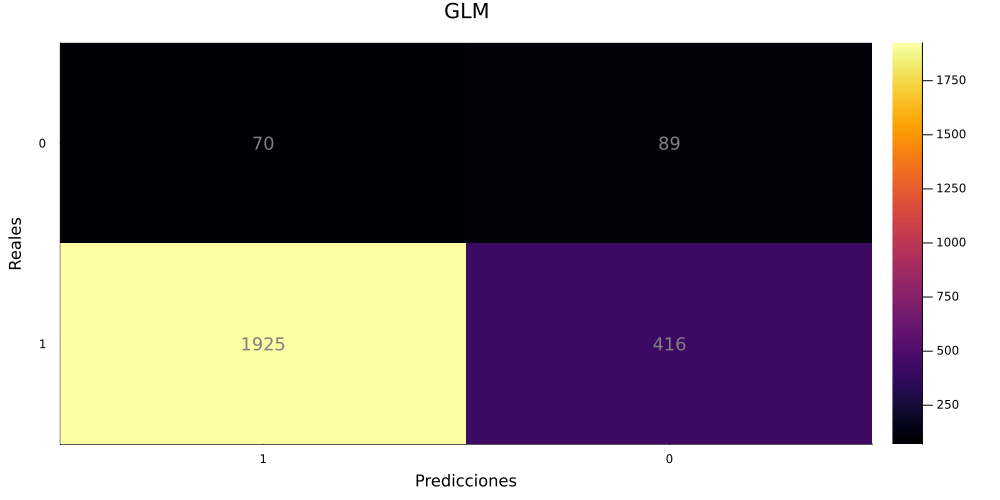

In [27]:
# Obtenemos nuestra matriz de confusíon  

p, cm_GLM = cm_plotter(true_pred, Churn_test.Exited, "GLM" )
display(plot(p))


In [28]:
accuracy, precision, recall, f1_score, TP, TN, FP, FN = calculate_metrics(cm_GLM.mat)

@show("Accuracy: $accuracy")
@show("Precision: $precision")
@show("Recall: $recall")
@show("F1_score: $f1_score")

"Accuracy: $(accuracy)" = "Accuracy: 0.8056"
"Precision: $(precision)" = "Precision: 0.17623762376237623"
"Recall: $(recall)" = "Recall: 0.559748427672956"
"F1_score: $(f1_score)" = "F1_score: 0.26807228915662645"


"F1_score: 0.26807228915662645"

False Positive Rate: [0.0, 0.0005012531328320802, 0.0005012531328320802, 0.0005012531328320802, 0.0010025062656641604, 0.0010025062656641604, 0.0015037593984962407, 0.0015037593984962407, 0.0015037593984962407, 0.0015037593984962407, 0.0020050125313283208, 0.0020050125313283208, 0.0020050125313283208, 0.002506265664160401, 0.002506265664160401, 0.0030075187969924814, 0.0035087719298245615, 0.0035087719298245615, 0.0035087719298245615, 0.0035087719298245615, 0.0035087719298245615, 0.0035087719298245615, 0.0035087719298245615, 0.0035087719298245615, 0.0040100250626566416, 0.0040100250626566416, 0.004511278195488722, 0.004511278195488722, 0.004511278195488722, 0.004511278195488722, 0.004511278195488722, 0.005012531328320802, 0.005012531328320802, 0.005012531328320802, 0.005513784461152882, 0.006015037593984963, 0.006015037593984963, 0.006516290726817042, 0.006516290726817042, 0.007017543859649123, 0.007017543859649123, 0.007017543859649123, 0.007017543859649123, 0.007518796992481203, 0.00

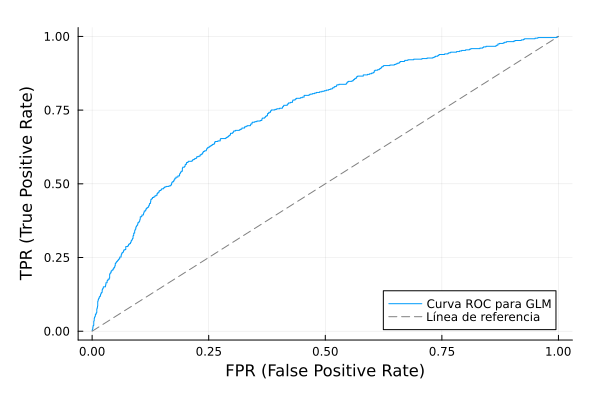

In [29]:
# Y la Curva de ROC

p, fpr_GLM, tpr_GLM = ROC_plotter(vec(prediction), Churn_test.Exited, "GLM" )
display(plot(p))

In [30]:
# Finalmente solo obtenemos el area bajo la curva de la curva de ROC
# recordemos que para que un ajuste se considere significativo, el AUC
# tiene que ser mayor a 0.7

auc_GLM = trapz(fpr_GLM, tpr_GLM)
println("AUC para GLM: ", auc_GLM)

AUC para GLM: 0.7458418323035312


## Flux: 

A partir de este punto comenzamos con el ajuste del modelo **Flux** a partir de los mismos datos que usamos para **GLM**.

In [31]:

#fm = @formula(Exited ~ CreditScore + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary + Gender_Encoded + Geography_Encoded)

# Definimos x_train, x_test, y_train y y_test a partir de los DF de prueba y entrenamiento
x_train = Matrix(select(Churn_train, 
    ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", 
     "HasCrCard", "IsActiveMember", "EstimatedSalary", 
     "Gender_Encoded", "Geography_Encoded"]))  # Selecciona y convierte a matriz

# Estandarizamos los datos de X para evitar que la funcíon de perdida diverga a infinito

x_test = Matrix(select(Churn_test, 
    ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", 
     "HasCrCard", "IsActiveMember", "EstimatedSalary", 
     "Gender_Encoded", "Geography_Encoded"]))  # Selecciona y convierte a matriz


y_test = Churn_test[!, "Exited"] 

y_train = Churn_train[!, "Exited"]  

y_train = reshape(y_train, 1, :)
y_test = reshape(y_test, 1, :)
                   
# Calculamos la media y desviación estándar del conjunto de entrenamiento
mean_train = mean(x_train, dims=1)
std_train = std(x_train, dims=1)
x_train = (x_train .- mean_train) ./ std_train
x_test = (x_test .- mean_train) ./ std_train


# Comenzamos deifniendo un modelo denso, que va a tomar 10 entradas (columnas) y devolver una sola caracteristica
# se espesifica el uso de la función de activación sigmoide.
predict_flux = Dense(10 => 1, σ)

# Definimos la funcion de perdida como la entropía cruzada binaria
using Flux: binarycrossentropy
loss(model, x, y) = binarycrossentropy(predict_flux(x), y)
#loss(model, x, y) = mean(abs2, (predict_flux(x) .-  y));


# Ademas, tomamos a nuestro optimizador como el descenso del gradiente con paso igual al 0.001
# y tomamos nuestro conjunto de datos igual a x_train y y_train

#opt = ADAM(0.001)
opt = Descent(0.001)
data = [(x_train', y_train)]

# Especificamos un ciclo de backpropagation de 200 epocas

for epoch in 200
    train!(loss, predict_flux, data, opt)
    if epoch % 50 == 0  # Monitorear cada 50 épocas
        println("Epoch $epoch - Loss: ", loss(predict_flux, x_train', y_train))
    end
end

# Obtenemos predicciones con nuestro modelo ajustado
prediction_flux = predict_flux(x_test')

# Pasamos de probabilidades a enteros
true_pred_flux = Proba_to_bin(prediction_flux, 0.5)


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(10 => 1, σ)
│   summary(x) = 10×7500 adjoint(::Matrix{Float64}) with eltype Float64
└ @ Flux C:\Users\USER\.julia\packages\Flux\Mhg1r\src\layers\stateless.jl:60


Epoch 200 - Loss: 0.800949
Predicciones para el método (10): [0, 1, 1, 0, 0, 1, 0, 0, 1, 0]


1×2500 Matrix{Int64}:
 0  1  1  0  0  1  0  0  1  0  1  1  0  …  1  1  1  0  0  1  1  1  0  1  0  1

In [32]:
# Y obtenemos la certeza de nuestro modelo
accuracy = mean(ifelse.(Churn_test.Exited .== vec(true_pred_flux), 1, 0))


0.5208

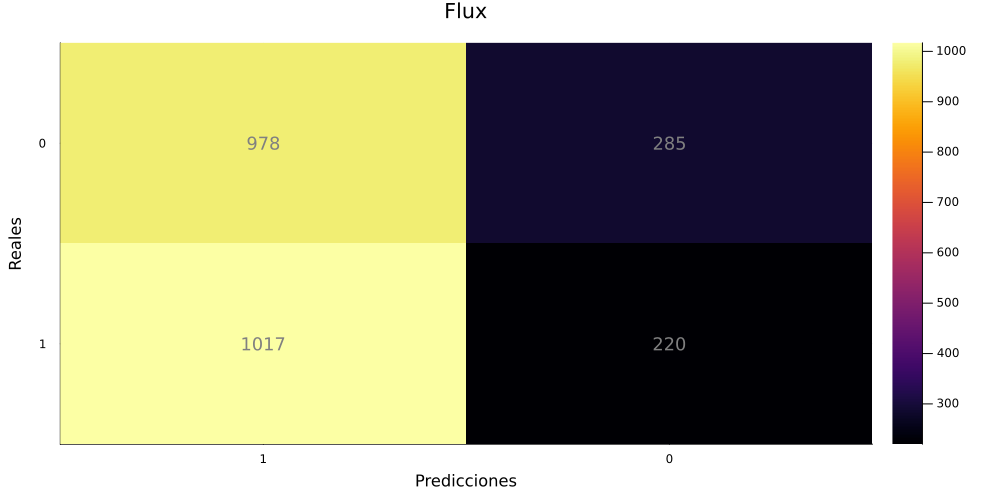

In [33]:
# Volvemos a graficar la matriz de confusión
p, cm_flux = cm_plotter(true_pred_flux, Churn_test.Exited, "Flux" )
display(plot(p))

In [34]:
accuracy, precision, recall, f1_score, TP, TN, FP, FN = calculate_metrics(cm_flux.mat)

@show("Accuracy: $accuracy")
@show("Precision: $precision")
@show("Recall: $recall")
@show("F1_score: $f1_score")

"Accuracy: $(accuracy)" = "Accuracy: 0.5208"
"Precision: $(precision)" = "Precision: 0.5643564356435643"
"Recall: $(recall)" = "Recall: 0.22565320665083136"
"F1_score: $(f1_score)" = "F1_score: 0.32239819004524883"


"F1_score: 0.32239819004524883"

In [35]:
# Guardamos los valores de depuracion de la curva de ROC

#=
(length(unique(vec(prediction_flux))))
unique(vec(prediction_flux))
(extrema(x_test))
=#

False Positive Rate: [0.0, 0.0, 0.0, 0.0005012531328320802, 0.0010025062656641604, 0.0010025062656641604, 0.0015037593984962407, 0.0020050125313283208, 0.002506265664160401, 0.002506265664160401, 0.0030075187969924814, 0.0035087719298245615, 0.0040100250626566416, 0.004511278195488722, 0.004511278195488722, 0.005012531328320802, 0.005012531328320802, 0.005012531328320802, 0.005513784461152882, 0.006015037593984963, 0.006015037593984963, 0.006516290726817042, 0.007017543859649123, 0.007518796992481203, 0.008020050125313283, 0.008521303258145364, 0.008521303258145364, 0.008521303258145364, 0.009022556390977444, 0.009523809523809525, 0.010025062656641603, 0.010526315789473684, 0.011027568922305764, 0.011027568922305764, 0.011528822055137845, 0.012030075187969926, 0.012531328320802004, 0.012531328320802004, 0.013032581453634085, 0.013032581453634085, 0.013533834586466165, 0.014035087719298246, 0.014035087719298246, 0.014536340852130326, 0.014536340852130326, 0.015037593984962405, 0.0155388

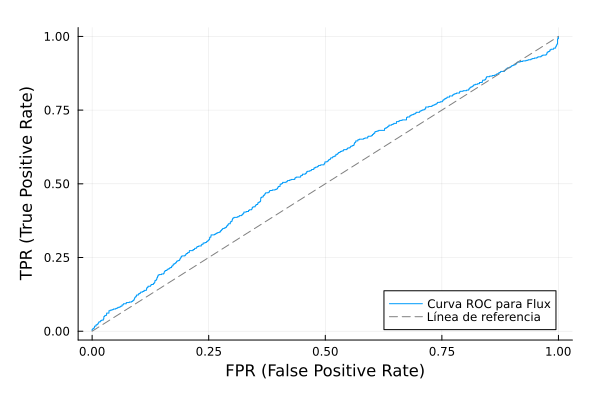

In [36]:
# La curva de ROC
p, fpr_flux, tpr_flux = ROC_plotter(vec(prediction_flux), Churn_test.Exited, "Flux" )
display(plot(p))


In [37]:
# Y obtener el area bajo la curva
auc_flux = trapz(fpr_flux, tpr_flux)
println("AUC para GLM: ", auc_flux)

AUC para GLM: 0.5437335914042533


## Conclusiones:

### Matriz de confusión:

En el modelo Flux, observamos una precisión moderada al clasificar correctamente la clase 0 y una menor capacidad para identificar correctamente la clase 1, por lo que el modelo parece estar más inclinado hacia la predicción de la clase 0 pudiendo deverse esto a que la clase 0 esta sobrerepesentada en los datos originales.<br><br>

### Curva ROC:

La curva ROC para el modelo Flux se aproxima a la diagonal de referencia, lo que indica que su capacidad para distinguir entre las clases es limitada.
En contraste, la curva ROC para el modelo GLM se encuentra más alejada de la línea de referencia, lo que sugiere una mayor discriminación entre las clases positivas y negativas en comparación con Flux.<br><br>

### Evaluación del desempeño:

Ambos modelos presentan limitaciones en términos de precisión y balance entre las clases. Sin embargo, el modelo GLM muestra un desempeño ligeramente superior en términos de discriminación (como lo refleja la curva ROC).<br><br>

### Generales:

Considerando el mejor ajuste de **GLM** y su implementación, se llega a la conclucisión de que la biblioteca es más amigable con los usuarios que no tienen experiencia ya que no es necesario el ajuste de parametros. Por otro lado, **Flux** es una bilbioteca más potente con la posibilidad de ajustar parametros, modelos, funciones de activación y pasos, lo que permite a usuarios experimentados en *ML* y con conocimientos suficientes de estadistica (caso que no es el mio) personalizar al modelo para un mejor ajuste; en caso contrario, la libertad de modificaciones en **Flux** se presta a descomponer el ajuste del modelo.<br><br>

### Sobre la construccion de la curva de ROC:

Nuestra función **ROC_Plotter**, demostró ser una mejor opcion que la biblioteca **ROCAnalysis** ya permitió obtener gráficas funcionales, sin embargo, es importante mencionar que la depuración de las entradas de la funciónn **ROC_Plotter** ayudan a identificar los posibles problemas que haya al gráficar.